In [1]:
import numpy as np
import itertools
from multiprocessing import Pool

import os
import pickle
import time
from pathlib import Path
from models.model_tester import *
from models.setting import MODEL_PATH, DATA_PATH, VALIDATION_PATH, TASK
from robust_beamforming.convex_baseline import ReweightedPenalty

N,M,max_ant = 10, 5, 5
np.random.seed(seed = 1000)
num_egs = 30

ftpl2 = []
nonftpl = []

folder_path = os.path.join(VALIDATION_PATH, 'N={},M={},L={}'.format(N,M,max_ant))
# folder_path = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/single_group_as_bm/validation_set/N={},M={},L={}'.format(N,M,max_ant)

if not os.path.isdir(folder_path):
    Path(folder_path).mkdir(exist_ok=True)

result_filepath = os.path.join(folder_path, 'egs_set_valid_30.pkl') 

MODEL_FOLDERPATH = os.path.join(MODEL_PATH, 'N={},M={},L={}'.format(N,M,max_ant))

num_nodes_eval = 0
time_total = 0
obj_bb = 0
obj_omar = 0
obj_opt = 0
t1 = time.time()

instances = np.random.randn(num_egs, 2, N, M)


In [17]:

######## ORACLE method #####################

# t1 = time.time()
# arguments_oracle = list(zip(list(instances), [max_ant]*num_egs))
# with Pool(10) as p:
#     out_oracle = p.map(solve_bb_pool, arguments_oracle)
#     print('pool ended')

# # out_oracle =[]
# # for i in range(num_egs):
# #     print('eg {}'.format(i))
# #     try:
# #         output = solve_bb_pool(arguments_oracle[i])
# #         out_oracle.append(output)        
# #     except SolverException as e:
# #         print('Solver Exception: ', e)
# #         out_oracle.append((None, np.inf, 0, 0))
    
# # Prune away the problem instances that were not feasible (could not be solved)
# for i in range(len(out_oracle)-1, -1, -1):
#     if out_oracle[i][1] == np.inf:
#         del out_oracle[i]
#         instances = np.concatenate((instances[:i,::], instances[i+1:,::]), axis=0)

# optimal_solution_list = [out_oracle[i][0] for i in range(len(out_oracle))]
# optimal_objective_list = [out_oracle[i][1] for i in range(len(out_oracle))]
# oracle_timesteps = np.mean([out_oracle[i][2] for i in range(len(out_oracle))])
# oracle_time = np.mean([out_oracle[i][3] for i in range(len(out_oracle))])


# data = (instances, optimal_solution_list, optimal_objective_list, oracle_timesteps, oracle_time)
# with open(result_filepath, 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)    

########### LOAD data ################################################

with open(result_filepath, 'rb') as handle:
    data = pickle.load(handle)
    instances, optimal_solution_list, optimal_objective_list, oracle_timesteps, oracle_time = data

########## OMAR'S Method #######################################
# mask_omar = [0]*N
# obj_omar = []
# omar_time = 0
# for i in range(len(instances)):
#     H = instances[i,0,:,:] + 1j*instances[i,1,:,:]
#     baseline = ReweightedPenalty(H=H, max_ant=max_ant)
#     obj_bb += optimal_objective_list[i]
#     t1 = time.time()
#     obj, mask = baseline.solve()
#     omar_time += time.time() - t1
#     obj_omar.append(obj)
#     mask_omar.append(mask)
# omar_time = omar_time/len(instances)
# print(omar_time)

mean_obj_omar = 0
mean_obj_bb = 0
num_success = 0
for i in range(len(obj_omar)):
    if obj_omar[i] is not None:
        mean_obj_omar += obj_omar[i]
        mean_obj_bb += optimal_objective_list[i]
        num_success += 1
mean_obj_omar /= num_success
mean_obj_bb /= num_success
success_rate = num_success/len(obj_omar)
omar_ogap = (mean_obj_omar - mean_obj_bb)/mean_obj_bb*100
########## GNN MODEL ###################################

model_ids = [13]

### FTPL ###
mask_omar = np.zeros(N)
for i in model_ids:
    MODEL_FILEPATH = os.path.join(MODEL_FOLDERPATH, 'gnn_1_iter_{}'.format(i))
    t1 = time.time()
    arguments_ml = list(zip(list(instances), 
                            optimal_solution_list, 
                            optimal_objective_list, 
                            range(len(instances)), 
                            [MODEL_FILEPATH]*len(instances), 
                            [max_ant]*len(instances), 
                            [mask_omar]*len(instances), 
                            [False]*len(instances)))
    
    out_ml = []
    for j in range(len(instances)):
        print('eg {}'.format(i))
        try:
            output = solve_ml_pool(arguments_ml[j])
            out_ml.append(output)
        except:
            pass
    
    avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
    avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
    ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))
    ftpl2.append((avg_ml_ogap, avg_ml_steps, ml_time, oracle_timesteps, omar_ogap, success_rate, omar_time ))
    
result_data = (out_ml, mask_omar, obj_omar, ftpl2)
ml_result_path = os.path.join(folder_path, 'egs_set_valid_30_result.pkl') 
with open(ml_result_path, 'wb') as handle:
    pickle.dump(result_data, handle, protocol=pickle.HIGHEST_PROTOCOL)    


eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/robust_beamforming/trained_models/N=10,M=5,L=5/gnn_1_iter_13
eg 13
setting policy path /

/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
len(obj_omar)

25

In [13]:
((np.array(obj_omar) - np.array(optimal_objective_list[:25]))/np.array(optimal_objective_list[:25])*100)

array([ 1.63953471e+00,  1.33303443e-09,  1.04510401e-08,  1.63530453e+00,
        2.58199536e+01,  7.37517472e+00,  1.65684864e-07,  1.00317924e-07,
        5.71437364e-08,  1.48049799e-07,  2.19069308e+01,  1.61406006e+01,
        6.01486055e-07,  2.03738916e+00,  1.10938869e+01,  1.71598081e+00,
        8.52236027e+00,  0.00000000e+00,  1.37229496e+01,  3.15285316e+01,
        6.78831187e+00,  3.17800221e+00, -1.87528460e-07,  1.49033235e-09,
        2.46218197e+01])

In [12]:
(np.array(obj_omar) - np.array(optimal_objective_list[:25]))

array([ 1.46913221e-02,  1.19797505e-11,  1.04279252e-10,  1.68267565e-02,
        2.43575363e-01,  6.31802719e-02,  1.23049015e-09,  7.82988785e-10,
        4.91188756e-10,  1.64523017e-09,  1.98557944e-01,  1.30738919e-01,
        6.80079504e-09,  1.83781648e-02,  7.84425835e-02,  1.17784950e-02,
        7.86137463e-02,  0.00000000e+00,  1.64728404e-01,  2.55450898e-01,
        7.45286009e-02,  2.41824632e-02, -1.21661103e-09,  1.19360077e-11,
        2.53700530e-01])

In [2]:
ml_result_path = os.path.join(folder_path, 'egs_set_valid_30_result.pkl') 
with open(ml_result_path, 'rb') as handle:
    result_data = pickle.load(handle)


In [4]:
out_ml, mask_omar, obj_omar, ftpl2 = result_data

In [12]:
num_success = 0
for i in range(len(obj_omar)):
    if obj_omar[i] is not None:
        num_success += 1
success_rate = num_success/len(obj_omar)

# BB test

In [1]:
from robust_beamforming.bb import solve_bb
import numpy as np


np.random.seed(seed = 100)
N = 8
M = 4
max_ant = 3

u_avg = 0
t_avg = 0
tstep_avg = 0
for i in range(1):
    H = np.random.randn(N, M) + 1j*np.random.randn(N,M)    
    instance = np.stack((np.real(H), np.imag(H)), axis=0)
    _, global_U, timesteps, t, lb_list, ub_list = solve_bb(instance, max_ant=max_ant, max_iter = 10000)
    u_avg += global_U
    t_avg += t
    tstep_avg += timesteps

print(u_avg, t_avg, tstep_avg, u_avg)

# print('bb solution: {}, optimal: {}'.format(global_U, optimal_f) )



timestep 0 23.511320109546148 1.0676975936477855

timestep 1 5.7937291299446025 1.0676975936477855

timestep 2 4.745314000098209 1.0676975936477855

timestep 3 4.745314000098209 1.304592921399743

timestep 4 4.745314000098209 1.5298091746198585

timestep 5 4.745314000098209 1.5298091746198585

timestep 6 4.593059335137716 1.7507906381058058

timestep 7 4.593059335137716 1.940311063628842

timestep 8 4.593059335137716 1.940311063628842

timestep 9 4.593059335137716 1.940311063628842

timestep 10 4.593059335137716 2.0165686812949457

timestep 11 4.593059335137716 2.0166600095048417

timestep 12 4.593059335137716 2.0166600095048417

timestep 13 4.593059335137716 2.4923252990082334

timestep 14 4.593059335137716 2.741925629485381

timestep 15 4.593059335137716 2.7994599914599867

timestep 16 4.593059335137716 2.827942947502898

timestep 17 4.593059335137716 3.014743065207813

timestep 18 4.593059335137716 3.014743065207813

timestep 19 4.593059335137716 3.1735165976561976

timestep 20 4.5

Text(0, 0.5, 'objective value')

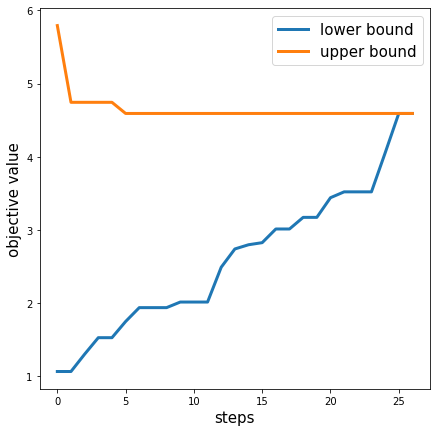

In [2]:
import matplotlib.pyplot as plt

fig2, ax = plt.subplots(1,1, figsize=(7,7))

plt.plot(lb_list, linewidth=3)
plt.plot(ub_list,linewidth=3)
plt.legend(['lower bound', 'upper bound'],fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.ylabel('objective value', fontsize=15)

In [3]:
fig2.savefig('data/n=8,m=4,l=3.pdf')